# What is this?

A small project that ultilize GroundedSAM model to annotate my dataset, using autodistill.

Steps in this notebook:
- Start with a set of 7 zebra images
- Use autodistill to label those images
- Use the labeled image to train a YOLOv8 model
- See the performance of the trained YOLOv8 model on unseen image

# Install, clone repo


In [1]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 3904MiB)
Setup complete ✅ (12 CPUs, 22.9 GB RAM, 97.1/105.2 GB disk)


In [2]:
from ultralytics import YOLO

In [6]:
import cv2
import torch

# check dataset: plot it up

In [3]:
from autodistill.utils import plot
import os, shutil

In [26]:
IMAGE_DIR_PATH = './images_zebra/'
SAMPLE_SIZE = 12

SAMPLE_GRID_SIZE = (2, 4)
SAMPLE_PLOT_SIZE = (16,8)

In [19]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["jpeg"])


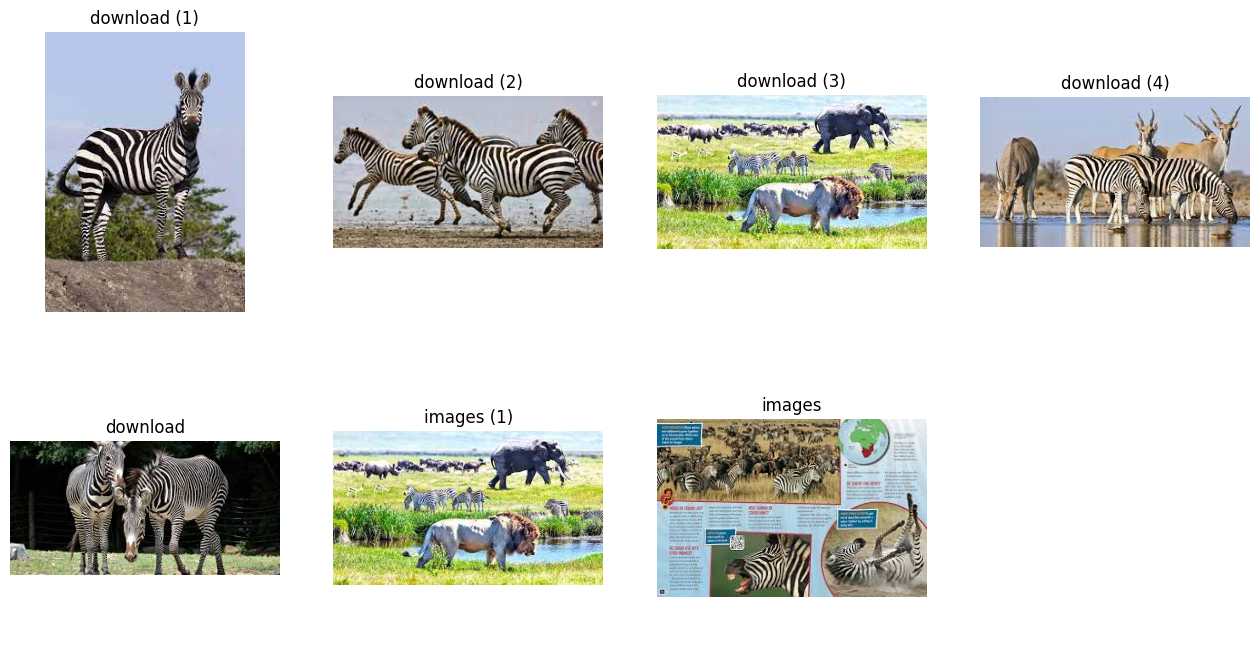

In [27]:
import cv2

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

# distil a model: label data

In [1]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology

base_model = GroundedSAM(ontology=CaptionOntology(
    {"zebra":"zebra"}
))

/media/thekhoi/My Drive/TheKhoi_Laptop/WORKSPACE/Jan2024/env_objectdet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


trying to load grounding dino directly


torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


final text_encoder_type: bert-base-uncased


In [ ]:
dataset = base_model.label(
    input_folder = f"images_zebra", 
    extension=".jpeg", 
    record_confidence=True)

## Check data with labels

In [15]:
import supervision as sv
import os

In [8]:
dataset_train = sv.DetectionDataset.from_yolo(
    images_directory_path = f"data/images_zebra_labeled/train/images", 
    annotations_directory_path = "data/images_zebra_labeled/train/labels",
    data_yaml_path = "data/images_zebra_labeled/data.yaml",
)

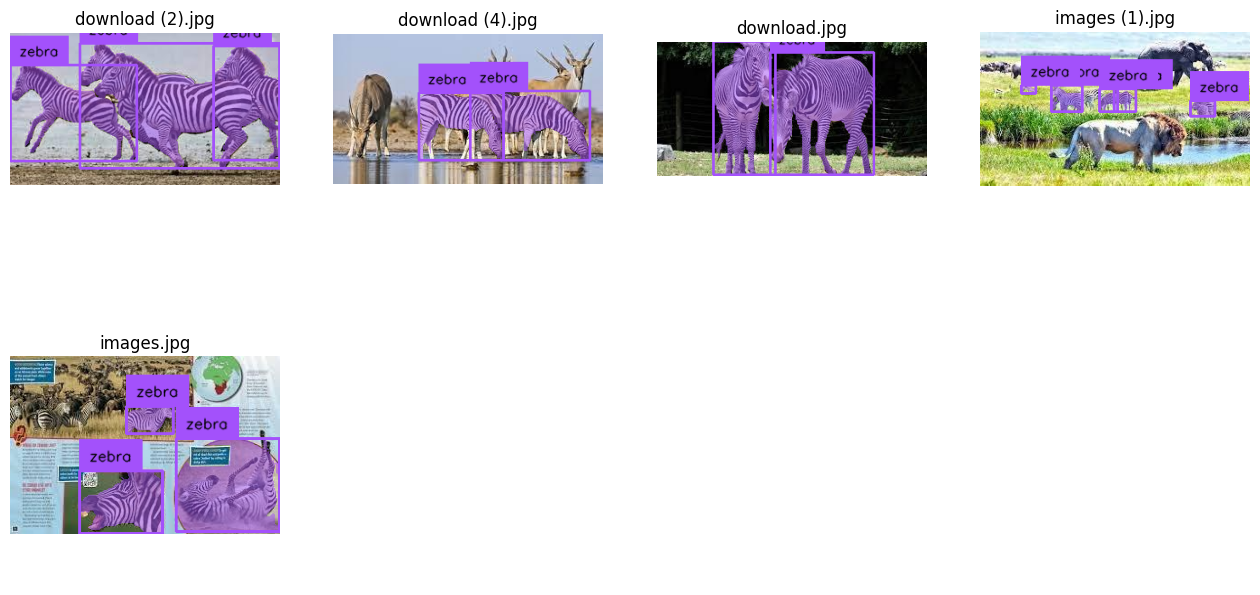

In [28]:
image_names = list(dataset_train.images.keys())[:SAMPLE_SIZE]
image_names_showing = [os.path.basename(image_name) for image_name in image_names.copy()]
mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset_train.images[image_name]
    annotations = dataset_train.annotations[image_name]
    labels = [
        dataset_train.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names_showing,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

If it **stuck** when splitting into train/valid (a known [bug](https://github.com/autodistill/autodistill/issues/112#issuecomment-1884488447)), lets DIY:

In [35]:
all_images = os.listdir(f"data/images_zebra_labeled/images")

train_test_split = 0.8

train_images = all_images[:int(len(all_images) * train_test_split)]
train_anotations = [f"data/images_zebra_labeled/annotations/{image_name[:-4]}.txt" for image_name in train_images]

TRAIN_IMAGE = "data/images_zebra_labeled/train/images"
TRAIN_ANOTATION = "data/images_zebra_labeled/train/labels"

# create train folder
for train_image in train_images:
    imgname = os.path.basename(train_image)
    train_image_new = TRAIN_IMAGE + imgname
    shutil.move(train_image, train_image_new)

    # process annotation
    train_annotation = f"data/images_zebra_labeled/annotations/{imgname[:-4]}.txt"
    train_annotation_new = TRAIN_ANOTATION + imgname[:-4] + ".txt"
    shutil.move(train_annotation, train_annotation_new)
    print(f"Moved {train_image} to {train_image_new}, \n   and {train_annotation} to {train_annotation_new}.")

# TODO: create valid folder

print(f"Train test split done. Ratio is {train_test_split}")

Train test split done. Ratio is 0.8


# Distill a model: train

In [12]:
from autodistill_yolov8 import YOLOv8

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [1]:
!nvidia-smi

Fri Jan 12 11:23:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.146.02             Driver Version: 535.146.02   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti     Off | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8               2W /  50W |      6MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
target_model = YOLOv8("yolov8s.pt")
target_model.train("data/images_zebra_labeled/data.yaml",
                   epochs = 100,
                   device=0)

Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 3904MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=images_zebra_labeled/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100.0%


AMP: checks passed ✅


train: Scanning /media/thekhoi/My Drive/TheKhoi_Laptop/WORKSPACE/Jan2024/images_zebra_labeled/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 168.32it/s]

train: New cache created: /media/thekhoi/My Drive/TheKhoi_Laptop/WORKSPACE/Jan2024/images_zebra_labeled/train/labels.cache



val: Scanning /media/thekhoi/My Drive/TheKhoi_Laptop/WORKSPACE/Jan2024/images_zebra_labeled/valid/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 359.92it/s]

val: New cache created: /media/thekhoi/My Drive/TheKhoi_Laptop/WORKSPACE/Jan2024/images_zebra_labeled/valid/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.59G        nan        nan        nan         46        640: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]

                   all          2          5     0.0155        0.2     0.0125    0.00667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.61G        nan        nan        nan         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all          2          5     0.0153        0.2     0.0125    0.00667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.63G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all          2          5     0.0161        0.2     0.0127    0.00684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.66G        nan        nan        nan         46        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          2          5     0.0149        0.2     0.0127    0.00669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.66G        nan        nan        nan         43        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          2          5     0.0161        0.2     0.0127    0.00669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.66G        nan        nan        nan         45        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all          2          5      0.017        0.2     0.0129    0.00703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all          2          5     0.0177        0.2    0.00697    0.00627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.66G        nan        nan        nan         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all          2          5     0.0184        0.2     0.0079    0.00711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.67G        nan        nan        nan         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all          2          5     0.0205        0.2    0.00847    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all          2          5     0.0219        0.2    0.00847    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.67G        nan        nan        nan         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          2          5     0.0214        0.2     0.0088    0.00792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.66G        nan        nan        nan         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all          2          5     0.0229        0.2     0.0088    0.00704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.66G        nan        nan        nan         24        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          2          5     0.0244        0.2    0.00954    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.67G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all          2          5     0.0254        0.2    0.00954    0.00763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all          2          5     0.0309        0.2     0.0121    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.66G        nan        nan        nan         40        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all          2          5     0.0339        0.2     0.0121    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.66G        nan        nan        nan         40        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all          2          5     0.0353        0.2     0.0121    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          2          5     0.0353        0.2     0.0121    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          2          5     0.0367        0.2     0.0121    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.66G        nan        nan        nan         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all          2          5     0.0367        0.2     0.0121    0.00972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.67G        nan        nan        nan         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          2          5      0.041        0.2     0.0146     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.66G        nan        nan        nan         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all          2          5      0.041        0.2     0.0146     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.66G        nan        nan        nan         39        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          2          5     0.0447        0.2     0.0157     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.67G        nan        nan        nan         45        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          2          5     0.0447        0.2     0.0157     0.0125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.67G        nan        nan        nan         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all          2          5     0.0471        0.2     0.0169     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.66G        nan        nan        nan         23        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all          2          5     0.0471        0.2     0.0169     0.0135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.66G        nan        nan        nan         44        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all          2          5     0.0573        0.2     0.0236     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.66G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          2          5     0.0573        0.2     0.0236     0.0152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.67G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all          2          5     0.0584        0.2     0.0255     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.66G        nan        nan        nan         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all          2          5     0.0584        0.2     0.0255     0.0167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.67G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all          2          5      0.065        0.2     0.0252     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.67G        nan        nan        nan         51        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all          2          5      0.065        0.2     0.0252     0.0166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.67G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          2          5     0.0564        0.2     0.0226     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.66G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all          2          5     0.0564        0.2     0.0226     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.66G        nan        nan        nan         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all          2          5     0.0698        0.2     0.0242     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.67G        nan        nan        nan         41        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all          2          5     0.0698        0.2     0.0242     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.67G        nan        nan        nan         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all          2          5     0.0661        0.2     0.0239     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.66G        nan        nan        nan         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all          2          5     0.0661        0.2     0.0239     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.66G        nan        nan        nan         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all          2          5     0.0653        0.2      0.022     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.66G        nan        nan        nan         40        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all          2          5     0.0653        0.2      0.022     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.66G        nan        nan        nan         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all          2          5      0.065        0.2     0.0218     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          2          5      0.065        0.2     0.0218     0.0151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.66G        nan        nan        nan         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all          2          5      0.145        0.4     0.0941     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.66G        nan        nan        nan         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          2          5      0.145        0.4     0.0941     0.0239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.67G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all          2          5      0.157        0.4     0.0906     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.67G        nan        nan        nan         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all          2          5      0.157        0.4     0.0906     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.67G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all          2          5      0.259        0.2      0.107     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.66G        nan        nan        nan         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          2          5      0.259        0.2      0.107     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.67G        nan        nan        nan         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          2          5      0.262        0.2      0.107     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.66G        nan        nan        nan         18        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all          2          5      0.262        0.2      0.107     0.0254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all          2          5      0.429        0.2      0.137     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.66G        nan        nan        nan         39        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all          2          5      0.429        0.2      0.137     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.67G        nan        nan        nan         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          2          5      0.429        0.2      0.137     0.0272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.66G        nan        nan        nan         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          2          5       0.43        0.2      0.129     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.66G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all          2          5       0.43        0.2      0.129     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.66G        nan        nan        nan         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all          2          5       0.43        0.2      0.129     0.0232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.66G        nan        nan        nan         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all          2          5      0.405        0.2      0.124     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.66G        nan        nan        nan         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all          2          5      0.405        0.2      0.124     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.66G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all          2          5      0.405        0.2      0.124     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.66G        nan        nan        nan         47        640: 100%|██████████| 1/1 [00:00<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all          2          5      0.325        0.2      0.122     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.66G        nan        nan        nan         45        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all          2          5      0.325        0.2      0.122     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.66G        nan        nan        nan         28        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all          2          5      0.325        0.2      0.122     0.0219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.66G        nan        nan        nan         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all          2          5      0.269        0.2     0.0988     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.67G        nan        nan        nan         40        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all          2          5      0.269        0.2     0.0988     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.66G        nan        nan        nan         30        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all          2          5      0.269        0.2     0.0988     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.67G        nan        nan        nan         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all          2          5      0.197        0.2      0.098      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.65G        nan        nan        nan         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all          2          5      0.197        0.2      0.098      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.67G        nan        nan        nan         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all          2          5      0.197        0.2      0.098      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.66G        nan        nan        nan         34        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all          2          5      0.197        0.2      0.095     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.66G        nan        nan        nan         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all          2          5      0.197        0.2      0.095     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.67G        nan        nan        nan         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all          2          5      0.197        0.2      0.095     0.0176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.66G        nan        nan        nan         33        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all          2          5      0.178        0.2     0.0744     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.66G        nan        nan        nan         27        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all          2          5      0.178        0.2     0.0744     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.67G        nan        nan        nan         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all          2          5      0.178        0.2     0.0744     0.0143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.67G        nan        nan        nan         35        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all          2          5      0.179        0.2     0.0723     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.66G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all          2          5      0.179        0.2     0.0723     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.66G        nan        nan        nan         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all          2          5      0.179        0.2     0.0723     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.67G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          2          5      0.185        0.2     0.0711     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.66G        nan        nan        nan         48        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all          2          5      0.185        0.2     0.0711     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.67G        nan        nan        nan         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all          2          5      0.185        0.2     0.0711     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.67G        nan        nan        nan         25        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all          2          5      0.187        0.2     0.0703     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.66G        nan        nan        nan         22        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all          2          5      0.187        0.2     0.0703     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.66G        nan        nan        nan         54        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all          2          5      0.187        0.2     0.0703     0.0126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.67G        nan        nan        nan         40        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all          2          5      0.186        0.2     0.0701     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.66G        nan        nan        nan         29        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all          2          5      0.186        0.2     0.0701     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.67G        nan        nan        nan         21        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all          2          5      0.186        0.2     0.0701     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.67G        nan        nan        nan         31        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all          2          5      0.186        0.2     0.0701     0.0122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.67G        nan        nan        nan         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all          2          5      0.186        0.2     0.0685     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.65G        nan        nan        nan         37        640: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all          2          5      0.186        0.2     0.0685     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.66G        nan        nan        nan         45        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all          2          5      0.186        0.2     0.0685     0.0119


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.67G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all          2          5      0.186        0.2     0.0685     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.69G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all          2          5      0.145        0.2     0.0701     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.72G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all          2          5      0.145        0.2     0.0701     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.74G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all          2          5      0.145        0.2     0.0701     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.75G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all          2          5      0.145        0.2     0.0701     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.74G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all          2          5      0.208        0.2     0.0891     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.74G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all          2          5      0.208        0.2     0.0891     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.75G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all          2          5      0.208        0.2     0.0891     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.74G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all          2          5      0.208        0.2     0.0891     0.0134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.75G        nan        nan        nan         15        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all          2          5      0.144        0.2     0.0607    0.00988



100 epochs completed in 0.056 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 22.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.1.0 🚀 Python-3.10.12 torch-2.1.2+cu121 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 3904MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


# Show the model's performance: supervision

In [12]:
import supervision as sv

In [ ]:
MODEL_DETECTION = "runs/detect/train5/weights/best.pt"
UNSEEN_IMAGE = "images_zebra_nonlabel/friendship_1280p.jpg"

In [5]:
model = YOLO(MODEL_DETECTION)
img = cv2.imread(UNSEEN_IMAGE)


In [13]:
results = model(img)[0]
detections = sv.Detections.from_ultralytics(results)


0: 384x640 4 zebras, 11.2ms
Speed: 16.7ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


In [14]:
bbox_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

In [15]:
labels = [
    model.model.names[class_id]
    for class_id in detections.class_id
]

In [16]:
annotated_img = bbox_annotator.annotate(
    scene = img, detections = detections
)


annotated_img = label_annotator.annotate(
    scene = annotated_img,
    detections = detections,
    labels = labels)

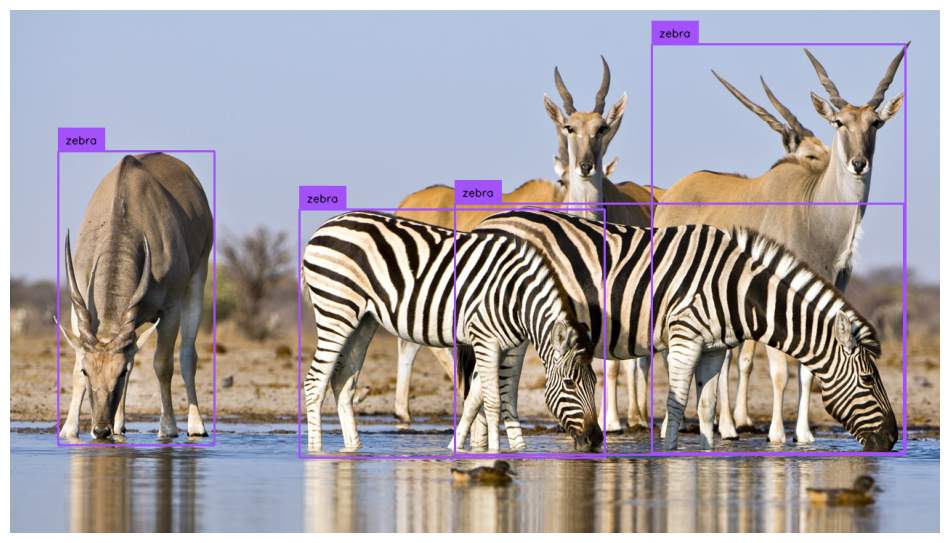

In [17]:
# result on unseen image
sv.plot_image(annotated_img)